In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

## Exploratory Data Analysis (EDA)

In [4]:
# Inspecting the first few rows of the data
print("Customers Data Head:")
print(customers.head())
print("\nProducts Data Head:")
print(products.head())
print("\nTransactions Data Head:")
print(transactions.head())

Customers Data Head:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Data Head:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions Data Head:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00

In [5]:
# Checking for missing values in each dataset
print("\nMissing values in Customers Dataset:")
print(customers.isnull().sum())
print("\nMissing values in Products Dataset:")
print(products.isnull().sum())
print("\nMissing values in Transactions Dataset:")
print(transactions.isnull().sum())


Missing values in Customers Dataset:
CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

Missing values in Products Dataset:
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64

Missing values in Transactions Dataset:
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


In [6]:
# Checking basic statistics for numerical columns in Transactions dataset
print("\nBasic statistics of Transactions dataset:")
print(transactions.describe())


Basic statistics of Transactions dataset:
          Quantity   TotalValue       Price
count  1000.000000  1000.000000  1000.00000
mean      2.537000   689.995560   272.55407
std       1.117981   493.144478   140.73639
min       1.000000    16.080000    16.08000
25%       2.000000   295.295000   147.95000
50%       3.000000   588.880000   299.93000
75%       4.000000  1011.660000   404.40000
max       4.000000  1991.040000   497.76000


## Data Preprocessing and Clustering 

In [8]:
# Merge the datasets to get relevant information for each transaction
merged_data = pd.merge(transactions, customers, on='CustomerID')
merged_data = pd.merge(merged_data, products, on='ProductID')

In [9]:
# Create new features for clustering:
# 1. Total spend per customer
customer_spend = merged_data.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_spend.columns = ['CustomerID', 'TotalSpend']

# 2. Frequency of purchase (number of transactions)
customer_frequency = merged_data.groupby('CustomerID')['TransactionID'].nunique().reset_index()
customer_frequency.columns = ['CustomerID', 'Frequency']

# 3. Recency of purchase (days since last purchase)
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
recency = merged_data.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency['Recency'] = (merged_data['TransactionDate'].max() - recency['TransactionDate']).dt.days
recency = recency[['CustomerID', 'Recency']]

In [10]:
# Merging the features
customer_profile = pd.merge(customer_spend, customer_frequency, on='CustomerID')
customer_profile = pd.merge(customer_profile, recency, on='CustomerID')

# Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_profile[['TotalSpend', 'Frequency', 'Recency']])

  File "C:\Users\Acer\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Acer\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Acer\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


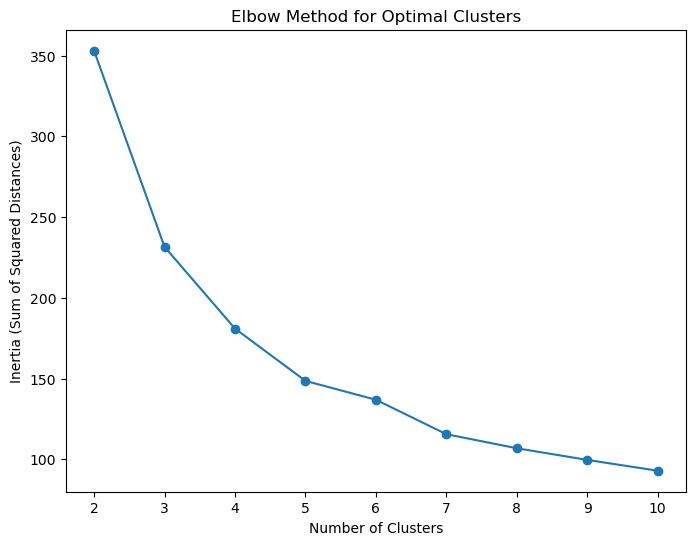

In [11]:
# Experimenting with different number of clusters between 2 to 10
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method to determine optimal clusters
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.show()

In [12]:
# KMeans Clustering (with 4 clusters as a starting point)
kmeans = KMeans(n_clusters=4, random_state=42) 
customer_profile['Cluster'] = kmeans.fit_predict(scaled_data)

##  Clustering Evaluation 

In [14]:
# Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_data, customer_profile['Cluster'])
print(f'\nDavies-Bouldin Index: {db_index}')


Davies-Bouldin Index: 1.0132126261526229


##  Visualizing the Clusters 

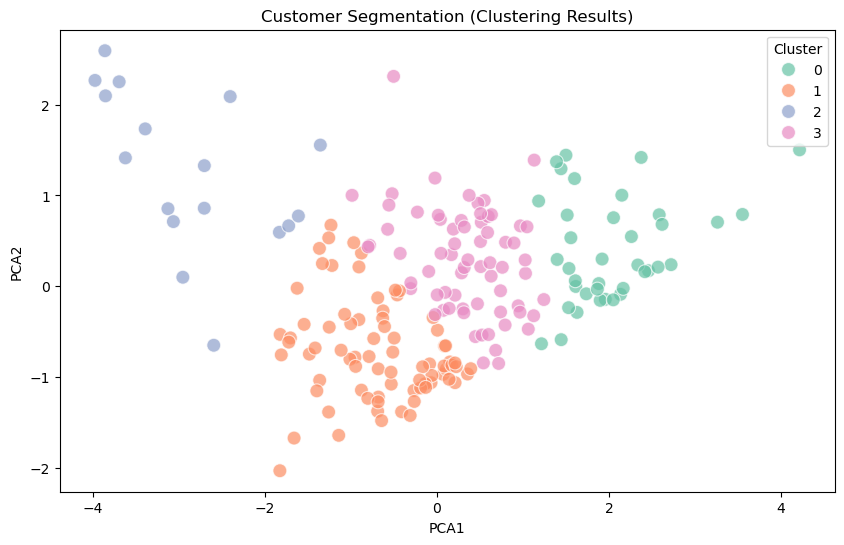

In [16]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
customer_profile['PCA1'] = pca_result[:, 0]
customer_profile['PCA2'] = pca_result[:, 1]

# Plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_profile, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100, alpha=0.7)
plt.title('Customer Segmentation (Clustering Results)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

##  Additional Insights 

In [18]:
# Average spend by each cluster
avg_spend_by_cluster = customer_profile.groupby('Cluster')['TotalSpend'].mean()
print("\nAverage Total Spend by Cluster:")
print(avg_spend_by_cluster)

# Other statistics by cluster
print("\nOther statistics by cluster:")
cluster_stats = customer_profile.groupby('Cluster').agg({
    'TotalSpend': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Recency': ['mean', 'std']
})
print(cluster_stats)


Average Total Spend by Cluster:
Cluster
0    5958.357895
1    2176.816883
2    1070.562353
3    4145.723881
Name: TotalSpend, dtype: float64

Other statistics by cluster:
          TotalSpend              Frequency               Recency           
                mean          std      mean       std        mean        std
Cluster                                                                     
0        5958.357895  1373.646678  8.236842  1.125484   34.736842  36.009521
1        2176.816883   743.855225  3.714286  1.098529   50.675325  42.434607
2        1070.562353   860.050129  1.764706  1.032558  243.823529  72.218622
3        4145.723881   859.830762  5.537313  1.091681   79.656716  45.285476
